slabMesh example notebook
-------

Eric Lindsey, Oct 2020

Runs a series of commands to make a triangular mesh for a portion of the Rakhine megathrust


In [22]:
# required imports for this code

#default python
from __future__ import division
from __future__ import absolute_import
from six.moves import range

# required anaconda packages (conda install): numpy, scipy, netcdf4, matplotlib, ipympl
import numpy as np
import numpy.linalg as la
from scipy import interpolate
import scipy.io as scio
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #requires ipympl package
%matplotlib widget

# available from conda forge (conda install -c conda-forge meshpy)
import meshpy.triangle as triangle

# local import
import slabMesh

# set modules to reload when changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


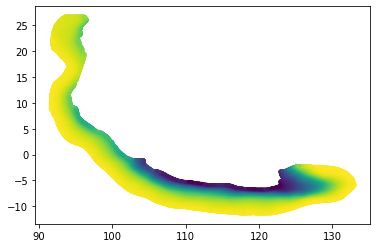

-673.2764 -3.1468403


In [2]:
# load the slab depth data points
fname = 'sum_slab2_dep_02.23.18.grd'
X,Y,Z = slabMesh.load_slab2_grid(fname)

# make a plot of the slab points, and print min/max of depths
plt.scatter(X,Y,5,Z)
plt.show()
print(np.min(Z),np.max(Z))

(224, 200)


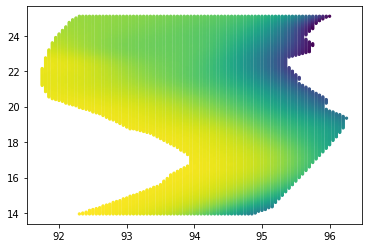

-174.12228 0.0


In [3]:
# crop a section of the fault
Xcrop,Ycrop,Zcrop_orig=slabMesh.crop_rectangle(X,Y,Z,90,100,13.95,25.1)

#offset the depth values, so they are relative to the seafloor (optional)
Zcrop=slabMesh.slabtop_at_zero(Zcrop_orig)

print(np.shape(Xcrop))
plt.scatter(Xcrop,Ycrop,5,Zcrop)
plt.show()
print(np.min(Zcrop),np.max(Zcrop))

224


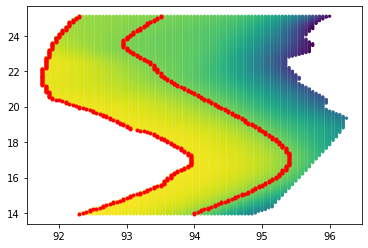

In [4]:
# get boundary points, from slab top to a specified depth.
# this currently relies on the assumption that the slab strike is motly north-south.
# Need to generalize for other megathrusts.

maxdepth = 35
left=[]
right=[]
for i in range(np.shape(Zcrop)[0]):
    row=Zcrop[i,:]
    validdata=np.where(row>-maxdepth)[0] #warning generated due to NaN values. They are ignored anyway
    if len(validdata>0):
        left.append([i,validdata[0]])
        right.append([i,validdata[-1]])
        
# must be missing a simpler way to do this here... argh
left=np.array(left)
right=np.array(right)
print(len(left))
Xleft=Xcrop[left[:,0],left[:,1]]
Yleft=Ycrop[left[:,0],left[:,1]]
Xright=Xcrop[right[:,0],right[:,1]]
Yright=Ycrop[right[:,0],right[:,1]]


plt.scatter(Xcrop,Ycrop,5,Zcrop)
plt.plot(Xleft,Yleft,'r.')
plt.plot(Xright,Yright,'r.')
plt.show()

[92.224 93.565 93.956 93.905 93.717 93.333 93.021 92.417 91.784 91.265
 90.872 90.657 90.467 90.645 90.645 91.249 91.645] [13.783 15.682 17.024 17.455 17.842 18.478 18.925 19.552 20.135 20.718
 21.312 21.989 23.598 24.123 24.123 24.815 25.126]


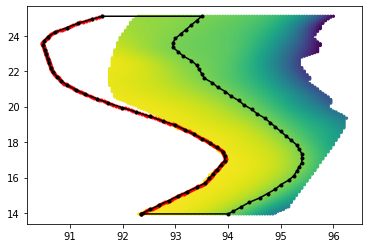

In [16]:
# extend the fault up to the surface by interpolation
# read megathrust trace coordinates
mt_trace = np.asarray(np.loadtxt('segments_mt.txt'))
mt_lon=mt_trace[:,0]
mt_lat=mt_trace[:,1]
print(mt_lon,mt_lat)

# interpolate fault trace longitude onto the latitude locations of the left boundary and replace the boundary with those values

f_mt_lon=interpolate.interp1d(mt_lat,mt_lon)
Xleft = f_mt_lon(np.asarray(Yleft))
plt.plot(Xleft,Yleft,'r.')
plt.scatter(Xcrop,Ycrop,5,Zcrop)

# keep only every nkeep points along the edge
nkeep=5
# create a closed polygon
Xpoly=np.append(np.append(np.append(Xleft[::nkeep],Xleft[-1]),Xright[::-nkeep]),[Xright[0],Xleft[0]])
Ypoly=np.append(np.append(np.append(Yleft[::nkeep],Yleft[-1]),Yright[::-nkeep]),[Yright[0],Yleft[0]])

plt.plot(Xpoly,Ypoly,'-k.')



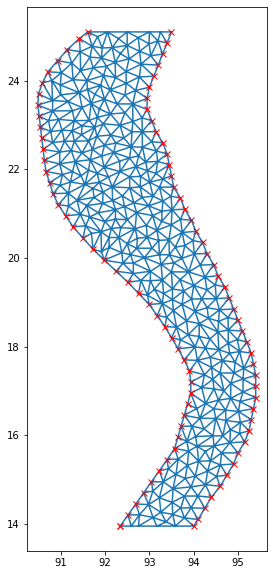

704 triangles


In [18]:
# create the mesh based on the input polygon. 
# Edge refinement is controlled by the 'nkeep' value in the cell above.
# Interior refinement is controlled by the function needs_refinement in slabMesh.
# You may have to manually adjust the hard-coded numbers in that function. 
# See meshPy documentation for more.

mesh_points,mesh_tris=slabMesh.make_mesh(Xpoly,Ypoly)

plt.figure(figsize=(10,10))
ax = plt.gca() 
ax.set_aspect(1)

plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
plt.plot(Xpoly,Ypoly,'rx')
plt.show()
print(len(mesh_tris),'triangles')

(14000, 2)


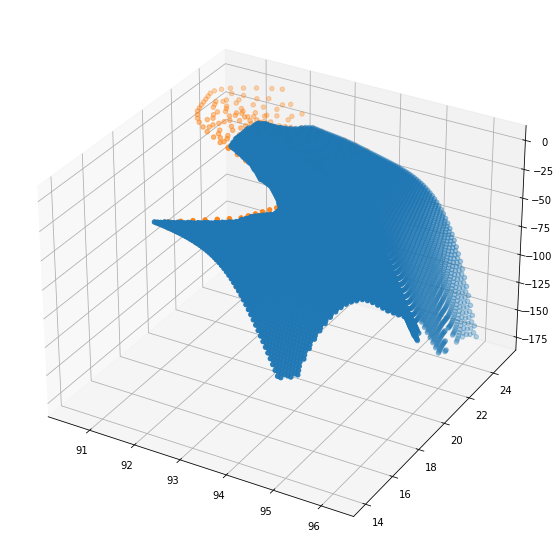

704 triangles


In [19]:
# assign depths to the nodes based on interpolation of the original depths

# conda/jupyter installations to enable interactive plots:
#
# conda install -c conda-forge ipympl
# jupyter labextension install @jupyter-widgets/jupyterlab-manager (must run again, even if installed before)
# jupyter labextension install jupyter-matplotlib
#

#points=np.array([Xcrop.ravel(),Ycrop.ravel()]).T # another ugly array creation
# do the interpolation to get depths
xvals=np.append(Xcrop.ravel(),Xleft)
yvals=np.append(Ycrop.ravel(),Yleft)
zvals=np.append(Zcrop.ravel(),0*Xleft)
mesh_depths = slabMesh.my_griddata(xvals,yvals, zvals, mesh_points[:,0], mesh_points[:,1])


fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.set_aspect(1)

ax.scatter(Xcrop,Ycrop,Zcrop)
#plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
ax.scatter(mesh_points[:,0],mesh_points[:,1],mesh_depths)
#plt.colorbar()

plt.show()
print(len(mesh_tris),'triangles')


In [30]:
#bathymetry correction - subtract shallowest point depth to make it zero
mesh_depths_nobathy = mesh_depths - max(mesh_depths)

# get an (n,3) array of the points
final_points=np.column_stack((mesh_points[:,0],mesh_points[:,1],mesh_depths_nobathy))

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
ax.plot_trisurf(final_points[:,0],final_points[:,1],final_points[:,2],triangles=mesh_tris)

# add an extra point to force aspect ratio - just for viewing. Really annoying that matplotlib doesn't allow 3D axis scaling
ax.scatter(102,22,-400,marker='',color='w')
#plt.colorbar()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [48]:
# save mesh to .mat file for Blocks input
fname='slab2_tri_myanmar_14N_25N_extended_sub%d_dep%d.mat'%(nkeep,maxdepth)
print(fname)
slabMesh.save_mesh_for_blocks(final_points,mesh_tris,fname)


slab2_tri_myanmar_14N_25N_extended_sub5_dep35.mat


In [53]:
#save mesh to .tri and .ned format for unicycle input
fname='slab2_tri_myanmar_14N_25N_extended_sub%d_dep%d'%(nkeep,maxdepth)
print(fname)
slabMesh.save_mesh_for_unicycle(final_points,mesh_tris,fname)


slab2_tri_myanmar_14N_25N_extended_sub5_dep35
